# Carga de paquetes

In [1]:
import os   # sistema operativo
from glob import glob, iglob # trabajo con carpetas
import shutil # creación de espacios de trabajo y dirección
#import itertools # herramientas de iteración
import numpy as np # linear algebra  
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import PIL

# Creación de  modelos
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

# Carga de datos

In [2]:
#shutil.rmtree("/kaggle/working/train2")
#shutil.rmtree("/kaggle/working/test2")

In [3]:
!pip install split-folders

In [4]:
import splitfolders
splitfolders.ratio("/kaggle/input/100-images-of-top-50-car-brands/imgs_zip/imgs/",
                  output="/kaggle/working/",
                  seed=1338,
                  ratio = (.8,.2))

Copying files: 4597 files [00:16, 274.37 files/s]


# Seleccionando las marcas de autos para clasificar

In [5]:
# crea la carpeta
os.mkdir('/kaggle/working/train2')
os.mkdir('/kaggle/working/test2')

In [6]:
shutil.move('/kaggle/working/train/Toyota','/kaggle/working/train2')
shutil.move('/kaggle/working/train/Hyundai','/kaggle/working/train2')
shutil.move('/kaggle/working/train/Mazda','/kaggle/working/train2')

shutil.move('/kaggle/working/val/Toyota','/kaggle/working/test2')
shutil.move('/kaggle/working/val/Hyundai','/kaggle/working/test2')
shutil.move('/kaggle/working/val/Mazda','/kaggle/working/test2')

'/kaggle/working/test2/Mazda'

In [7]:
archivos = glob('/kaggle/working/train2/*/*.jpg')
total_archivos=len(archivos)
total_archivos

217

# Preprocesamiento de imagenes

In [8]:
# Definiendo parametros de la imagenes
batch_size = 32
img_height = 240
img_width = 240

In [9]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  '/kaggle/working/train2',
  #validation_split=0.2,
  #subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 217 files belonging to 3 classes.


In [10]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  '/kaggle/working/test2',
  #validation_split=0.2,
  #subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 56 files belonging to 3 classes.


In [11]:
class_names = train_ds.class_names
print(class_names)

['Hyundai', 'Mazda', 'Toyota']


In [12]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 240, 240, 3)
(32,)


#image_batch es un tensor de la forma (32, 180, 180, 3) . Este es un lote de 32 imágenes de forma 180x180x3 (la última dimensión se refiere a los canales #de color RGB). El label_batch es un tensor de la forma (32,) , estas son las etiquetas correspondientes a las 32 imágenes.

In [13]:
# Mejora el rendimiento del modeo evaluando la carga de las imagenes en memoria
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Modelo

In [14]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)), # la estandarización de la imagenes se hace en el propio modelo
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [15]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 240, 240, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 240, 240, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 120, 120, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 120, 120, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 60, 60, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)        1

In [17]:
# Aprendizaje del modelo.
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
7/7 [==============================] - 13s 185ms/step - loss: 3.3424 - accuracy: 0.3272 - val_loss: 1.1682 - val_accuracy: 0.3750
Epoch 2/10
7/7 [==============================] - 0s 36ms/step - loss: 1.1069 - accuracy: 0.3779 - val_loss: 1.0993 - val_accuracy: 0.3036
Epoch 3/10
7/7 [==============================] - 0s 35ms/step - loss: 1.0792 - accuracy: 0.4194 - val_loss: 1.1235 - val_accuracy: 0.3393
Epoch 4/10
7/7 [==============================] - 0s 36ms/step - loss: 0.9981 - accuracy: 0.5161 - val_loss: 1.0539 - val_accuracy: 0.4643
Epoch 5/10
7/7 [==============================] - 0s 35ms/step - loss: 0.9153 - accuracy: 0.5899 - val_loss: 1.1067 - val_accuracy: 0.4107
Epoch 6/10
7/7 [==============================] - 0s 35ms/step - loss: 0.7613 - accuracy: 0.6912 - val_loss: 1.0271 - val_accuracy: 0.4643
Epoch 7/10
7/7 [==============================] - 0s 35ms/step - loss: 0.5361 - accuracy: 0.8295 - val_loss: 1.4671 - val_accuracy: 0.4107
Epoch 8/10
7/7 [=========

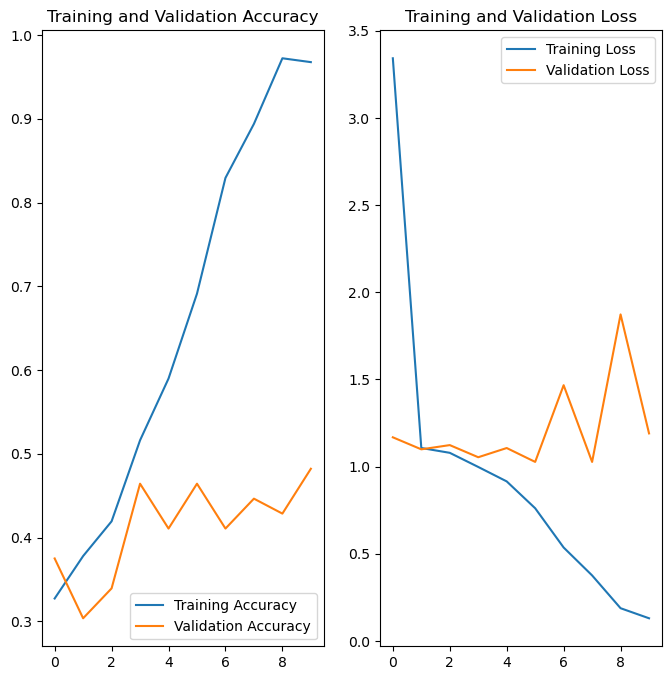

In [18]:
# Evaluacion del modelo
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Evitar el sobreajuste

In [19]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

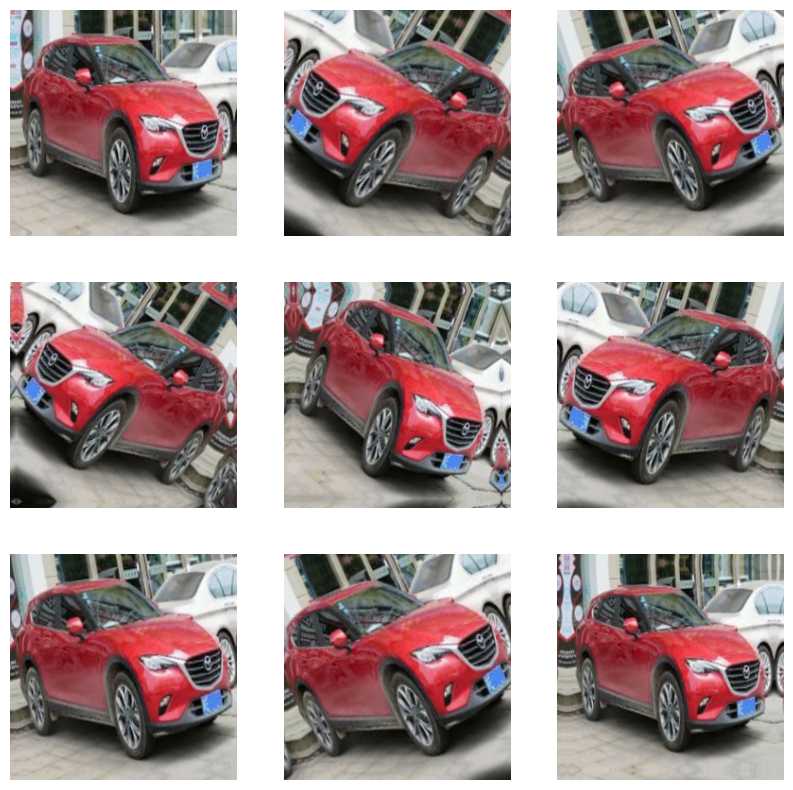

In [20]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [21]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),  # Esta capa se utiliza para evitar el sobreajuste dejando un % de      
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [22]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [23]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 240, 240, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 240, 240, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 240, 240, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 120, 120, 16)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 120, 120, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 60, 60, 32)       0         
 2D)                                                  

In [24]:
epochs = 25
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/25


2023-07-26 20:48:19.432941: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_2/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


7/7 [==============================] - 3s 91ms/step - loss: 2.7259 - accuracy: 0.3272 - val_loss: 1.1704 - val_accuracy: 0.3393
Epoch 2/25
7/7 [==============================] - 0s 55ms/step - loss: 1.1118 - accuracy: 0.3272 - val_loss: 1.0956 - val_accuracy: 0.3393
Epoch 3/25
7/7 [==============================] - 0s 55ms/step - loss: 1.0956 - accuracy: 0.4240 - val_loss: 1.0883 - val_accuracy: 0.4286
Epoch 4/25
7/7 [==============================] - 0s 61ms/step - loss: 1.0652 - accuracy: 0.4516 - val_loss: 1.0525 - val_accuracy: 0.4643
Epoch 5/25
7/7 [==============================] - 0s 53ms/step - loss: 1.0621 - accuracy: 0.4194 - val_loss: 1.0304 - val_accuracy: 0.4107
Epoch 6/25
7/7 [==============================] - 0s 53ms/step - loss: 1.0462 - accuracy: 0.4793 - val_loss: 1.0190 - val_accuracy: 0.4464
Epoch 7/25
7/7 [==============================] - 0s 54ms/step - loss: 1.0104 - accuracy: 0.4977 - val_loss: 1.0139 - val_accuracy: 0.4464
Epoch 8/25
7/7 [======================

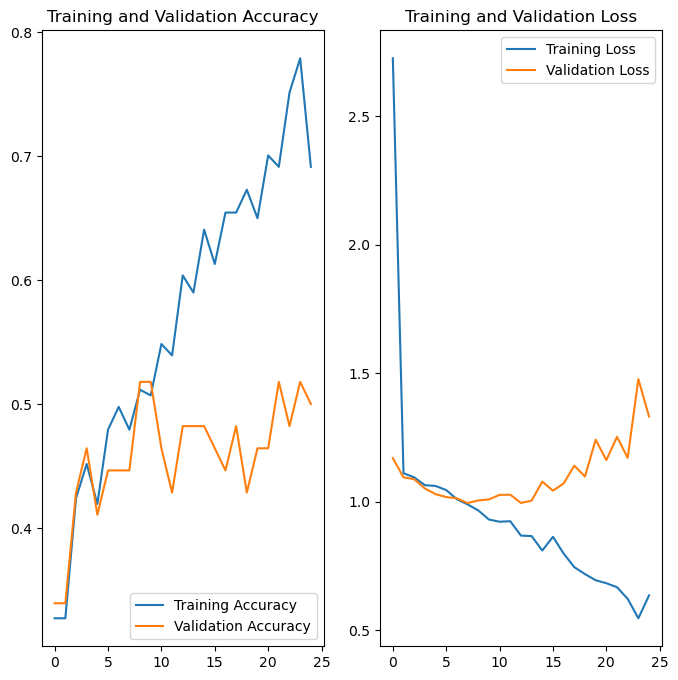

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [26]:
#auto = '/kaggle/input/prueba-tf/Hyundai_Creta.jpg'
#autos_path = tf.keras.utils.get_file('Hyundai_Creta', origin=auto)

img = tf.keras.utils.load_img(
    '/kaggle/input/prueba-tf/Hyundai_Creta.jpg', target_size=(img_height, img_width)
)

#img = tf.keras.utils.load_img()
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "Esta imagen probablemente es {} with a {:.2f} % de confianza."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 210ms/step
Esta imagen probablemente es Toyota with a 69.80 % de confianza.


In [27]:
# Save it as a h5 file
from tensorflow.keras.models import load_model
model.save('model.h5',overwrite=True)